# Analysis on LandVision data (Improvements Ratio and Rental Status)

This code makes some calcs on parcels

In [1]:
import osmnx as ox
from IPython.display import Image
%matplotlib inline
ox.config(log_console=True, use_cache=True)

import pandas as pd, numpy as np
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely import wkt
import geopandas

import matplotlib.pyplot as plt

## Step 1 Import LandVision and Parcel Data and Check APN match

### Read in county parcel data shapefiles

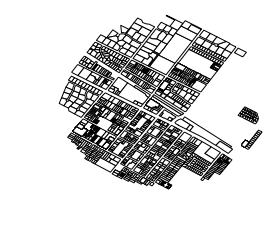

In [2]:
fruit_pz = geopandas.read_file('GIS/Parcel_Zoning/Subset/fruit_res.shp')
mp_pz = geopandas.read_file('GIS/Parcel_Zoning/Subset/mp_res.shp')
soto_pz = geopandas.read_file('GIS/Parcel_Zoning/Subset/soto_res.shp')
sl_pz = geopandas.read_file('GIS/Parcel_Zoning/Subset/sl_res.shp')

f, ax = plt.subplots(1, figsize=(4, 4))
ax = mp_pz.plot(ax = ax, color='white', edgecolor='black', linewidth=1)
ax.set_axis_off()
plt.show()

In [3]:
soto_pz.columns

Index(['level_0', 'index', 'arb', 'assetid', 'block', 'bpp', 'cncl_dist',
       'date_crtn_', 'time_crtn_', 'eng_dist', 'eng_dist_d', 'id', 'lot',
       'date_lst_m', 'time_lst_m', 'map_ref', 'mapsheet', 'mod', 'pin', 'pind',
       'shape_area', 'shape_leng', 'tract', 'key', 'name', 'lat', 'lon',
       'index_righ', 'zone_cmplt', 'zone_base', 'dist_stati', 'parcel_are',
       'parcel_len', 'parcel_quo', 'geometry'],
      dtype='object')

In [4]:
soto_pz2 = soto_pz[['assetid', 'bpp', 'id','lot','shape_area','zone_cmplt','zone_base','parcel_are','geometry']]
sl_pz2 = sl_pz[['assetid', 'bpp', 'id','lot','shape_area','zone_cmplt','zone_base','parcel_are','geometry']]

soto_pz2.head(3)

,assetid,bpp,id,lot,shape_area,zone_cmplt,zone_base,parcel_are,geometry
0,1475921.0,5175027003,331.0,23,5433.818538,R2-1-CUGU,Multi-Family Residential,5455.762698,POLYGON ((-118.2104603343075 34.05096083937416...
1,1475938.0,5175017010,332.0,10,5495.704778,R2-1-CUGU,Multi-Family Residential,5517.906385,"POLYGON ((-118.2094280859165 34.0507960205358,..."
2,1476094.0,5175027019,336.0,38,5187.663818,R2-1-CUGU,Multi-Family Residential,5208.608658,POLYGON ((-118.2105268789543 34.05085647001695...


In [5]:
soto_pz_agg = soto_pz2.dissolve(by='bpp', aggfunc='sum')
sl_pz_agg = sl_pz2.dissolve(by='bpp', aggfunc='sum')

soto_pz_agg['bpp'] = soto_pz_agg.index
sl_pz_agg['bpp'] = sl_pz_agg.index

sl_pz_agg.head(2)

,geometry,assetid,id,shape_area,parcel_are,bpp
bpp,,,,,,
5420002001,POLYGON ((-118.2564432297304 34.08764537002125...,1370808.0,250.0,6125.383501,6149.620724,5420002001
5420002002,POLYGON ((-118.2561242034366 34.08778610727912...,1370948.0,253.0,6125.383082,6149.622451,5420002002


In [6]:
print(len(soto_pz))
print(len(soto_pz_agg))

print(len(sl_pz))
print(len(sl_pz_agg))

2355
1857
2796
2245


#### Test for parcel IDs I think

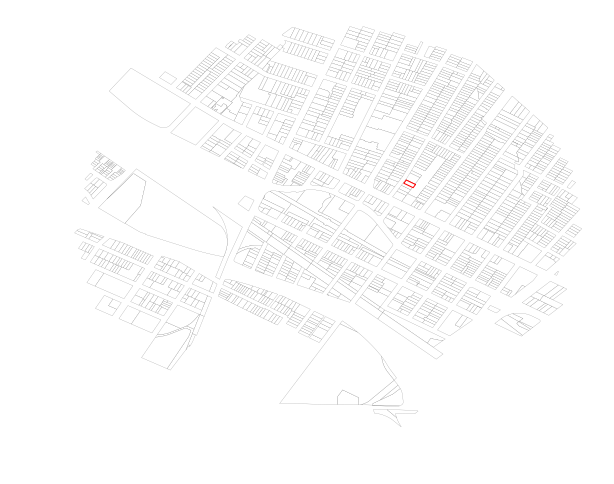

In [7]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax = fruit_pz.plot(ax = ax, color='white', edgecolor='black', linewidth=.1)
ax = fruit_pz[fruit_pz['apn'] == '33-2132-61'].plot(ax = ax, color='white', edgecolor='red', linewidth=1)

ax.set_axis_off()
plt.show()

In [8]:
fruit_pz.head(2)

,index,apn,apn_sort,book,centroid_x,centroid_y,clca_categ,comments,date_creat,date_updat,...,index_righ,BASEZONE,OVERLAY,ZNLABEL,zone_base,dist_stati,parcel_are,parcel_len,parcel_quo,geometry
0,5,33-2127-11,033 212701100,33,6.064269e+06,2.111500e+06,None,None,2004-06-07,2004-06-07,...,30.0,RM-3,None,RM-3,Multi-Family Residential,756.169981,3804.304088,303.358662,0.519485,POLYGON ((-122.2209985275363 37.78121209779937...
1,6,33-2136-27-1,033 213602701,33,6.065076e+06,2.110309e+06,None,None,2004-06-07,2004-06-07,...,27.0,RM-2,None,RM-2,Multi-Family Residential,622.041286,5958.258968,345.136906,0.628561,POLYGON ((-122.2181174853883 37.77796759230895...


In [9]:
fruit_pz.crs

{'init': 'epsg:4269'}

### Read in LandVision data as text files

In [34]:
#specify datatypes so FIPS numbers, etc. read in properly
dtypes = {'PARCEL_APN': 'str'}
#colnames = ['Geo_STATE','Geo_FIPS','ACS16_5yr_B25003003',]

path1 = 'Landvision/06001/' # select folder with data in it
path2 = 'Landvision/06081/' # select folder with data in it
path3 = 'Landvision/06037/' # select folder with data in it

alameda = pd.read_csv(path1 + 'Propertypoints_06001.txt', sep=',', dtype=dtypes, encoding = "ISO-8859-1")
sanmateo = pd.read_csv(path2 + 'Propertypoints_06081.txt', sep=',', dtype=dtypes, encoding = "ISO-8859-1")
lac = pd.read_csv(path3 + 'Propertypoints_06037.txt', sep=',', dtype=dtypes, encoding = "ISO-8859-1")

alameda.head(2)

,PARCEL_APN,FIPS_CODE,FIPS_MUNI_CODE,FIPS_STATE_CODE,XCOORD,YCOORD,ACREAGE,ADDRESS_ID,AGGR_ACREAGE,AGGR_GROUP,...,VAL_ASSD_LAND,VAL_MARKET,VAL_MRKT_IMPRV,VAL_MRKT_LAND,VAL_TRANSFER,YR_BLT,YR_BLT_EFFECT,YR_MRKT_VAL,ZONING,GEOM
0,66-2761-129,6001,1,6,-122.307471,37.897224,7.64,US_06_001_177637528,7,US_06_001_66-2763-140,...,158023,0,0,0,430000,1988,0,NaN,NaN,POINT (-122.30747082392269 37.8972238800709)
1,66-2761-129,6001,1,6,-122.307471,37.897224,7.64,US_06_001_177637527,7,US_06_001_66-2763-14,...,88752,0,0,0,268000,1988,0,NaN,NaN,POINT (-122.30747082392269 37.8972238800709)


In [35]:
columns = ['PARCEL_APN','ASSESSEE_MAIL_ADDR','ASSESSEE_MAIL_UNIT_NUMBER','ASSESSEE_MAIL_CITY',
           'ASSESSEE_MAIL_UNIT_PREFIX','ASSESSEE_OWNER_NAME_1','OWNER_NAME_1',
           'MAIL_ADDR','MAIL_UNIT_NUMBER','MAIL_UNIT_PREFIX','MAIL_CITY','OWNER_OCCUPIED',
           'SITE_ADDR','SITE_CITY','SITE_UNIT_PREFIX','SITE_UNIT_NUMBER','ASMT_OWNER_OCCUPIED',
           'VAL_ASSD','VAL_ASSD_IMPRV','VAL_ASSD_LAND','IMPRV_PCT','BEDROOMS','TAXAPN','GEOM']

alameda_trim = alameda.loc[:,columns]
sanmateo_trim = sanmateo.loc[:,columns]
lac_trim = lac.loc[:,columns]

lac_trim.head(2)

,PARCEL_APN,ASSESSEE_MAIL_ADDR,ASSESSEE_MAIL_UNIT_NUMBER,ASSESSEE_MAIL_CITY,ASSESSEE_MAIL_UNIT_PREFIX,ASSESSEE_OWNER_NAME_1,OWNER_NAME_1,MAIL_ADDR,MAIL_UNIT_NUMBER,MAIL_UNIT_PREFIX,...,SITE_UNIT_PREFIX,SITE_UNIT_NUMBER,ASMT_OWNER_OCCUPIED,VAL_ASSD,VAL_ASSD_IMPRV,VAL_ASSD_LAND,IMPRV_PCT,BEDROOMS,TAXAPN,GEOM
0,3251013004,PO BOX 1000,NaN,LEBEC,NaN,TEJON RANCHCORP INC,TEJON RANCHCORP INC,PO BOX 1000,NaN,NaN,...,NaN,NaN,NaN,11441,0,11441,NaN,0,3251-013-004,POINT (-118.85200510465612 34.801389732006356)
1,3251011027,3537 LOWRY RD,NaN,LOS ANGELES,NaN,BURK HARRIS BURK INC,BURK HARRIS BURK INC,3537 LOWRY RD,NaN,NaN,...,NaN,NaN,NaN,3426,0,3426,NaN,0,3251-011-027,POINT (-118.8563828013411 34.8023514381758)


In [36]:
alameda_trim[alameda_trim['PARCEL_APN'] == '33-2132-54']

,PARCEL_APN,ASSESSEE_MAIL_ADDR,ASSESSEE_MAIL_UNIT_NUMBER,ASSESSEE_MAIL_CITY,ASSESSEE_MAIL_UNIT_PREFIX,ASSESSEE_OWNER_NAME_1,OWNER_NAME_1,MAIL_ADDR,MAIL_UNIT_NUMBER,MAIL_UNIT_PREFIX,...,SITE_UNIT_PREFIX,SITE_UNIT_NUMBER,ASMT_OWNER_OCCUPIED,VAL_ASSD,VAL_ASSD_IMPRV,VAL_ASSD_LAND,IMPRV_PCT,BEDROOMS,TAXAPN,GEOM
129293,33-2132-54,1436 36TH AVE,1,OAKLAND,#,BREACH SAMANTHA,"BREACH, SAMANTHA",1436 36TH AVE # 1,1,#,...,NaN,NaN,Y,485878,340115,145763,70.00,3,33-2132-54,POINT (-122.22125868218451 37.776366247568674)
129294,33-2132-54,2544 ETNA ST,NaN,BERKELEY,NaN,ALTMAN DANIEL & NANCY TRS,"JAFFERJI, KHOZEMA SHAMSUDDIN",1436 36TH AVE,NaN,NaN,...,NaN,NaN,NaN,173310,121317,51993,70.00,1,33-2132-55,POINT (-122.22125868218451 37.776366247568674)
129295,33-2132-54,2544 ETNA ST,NaN,BERKELEY,NaN,ALTMAN DANIEL & NANCY TRS,"ALTMAN, DANIEL",2544 ETNA ST,NaN,NaN,...,NaN,NaN,NaN,173310,121317,51993,70.00,1,33-2132-56,POINT (-122.22125868218451 37.776366247568674)
129296,33-2132-54,1436 36TH AVE,J3,OAKLAND,APT,SCHULTE MELISSA A,"SCHULTE, MELISSA A",1436 36TH AVE APT J3,J3,APT,...,NaN,NaN,Y,489000,342300,146700,70.00,1,33-2132-57,POINT (-122.22125868218451 37.776366247568674)
129297,33-2132-54,2544 ETNA ST,NaN,BERKELEY,NaN,ALTMAN DANIEL & NANCY TRS,"NEILANDER, DENAL E",1436 36TH AVE # 12,12,#,...,NaN,NaN,NaN,294249,268220,26029,91.15,3,33-2132-58,POINT (-122.22125868218451 37.776366247568674)
129298,33-2132-54,2544 ETNA ST,NaN,BERKELEY,NaN,FRUITVALE GARDENS LLC,FRUITVALE GARDENS LLC,2544 ETNA ST,NaN,NaN,...,NaN,NaN,NaN,0,0,0,NaN,0,33-2132-61,POINT (-122.22125868218451 37.776366247568674)


In [9]:
#alameda_trim[alameda_trim['PARCEL_APN'] == '33-2132-54'].to_csv('landvision_test.csv')

### Turn the dataframe into a geodataframe using the coordinates of the parcel mid-point

We are going to overlay the parcel points on the parcel polygons as a way to match them. The APNs are a little tricky and don't always match up, especially with condo parcels where there may be same or different APNs across units. This way we will not lose any data. See the parcel ID # 33-2132-54 example above

In [37]:
alameda_trim['GEOM'] = alameda_trim['GEOM'].apply(wkt.loads)
sanmateo_trim['GEOM'] = sanmateo_trim['GEOM'].apply(wkt.loads)
lac_trim['GEOM'] = lac_trim['GEOM'].apply(wkt.loads)

geo_alameda = geopandas.GeoDataFrame(alameda_trim, geometry='GEOM')
geo_sanmat = geopandas.GeoDataFrame(sanmateo_trim, geometry='GEOM')
geo_lac = geopandas.GeoDataFrame(lac_trim, geometry='GEOM')

## Step 2: Overlay parcel points from Landvision with 0.5 mi radius parcels around stations

In [38]:
geo_alameda.crs = fruit_pz.crs
geo_sanmat.crs = mp_pz.crs
geo_lac.crs = soto_pz_agg.crs

fruit_lv = geopandas.sjoin(geo_alameda, fruit_pz, how='inner', op ='within').reset_index()
mp_lv = geopandas.sjoin(geo_sanmat, mp_pz, how='inner', op ='within').reset_index()
soto_lv = geopandas.sjoin(geo_lac, soto_pz_agg, how='inner', op ='within').reset_index()
sl_lv = geopandas.sjoin(geo_lac, sl_pz_agg, how='inner', op ='within').reset_index()

In [39]:
fruit_lv.to_file('Landvision/Merged/fruit_lv.shp')
mp_lv.to_file('Landvision/Merged/mp_lv.shp')
soto_lv.to_file('Landvision/Merged/soto_lv.shp')
sl_lv.to_file('Landvision/Merged/sl_lv.shp')

# Load back in the parcel datasets with LandVision data attached

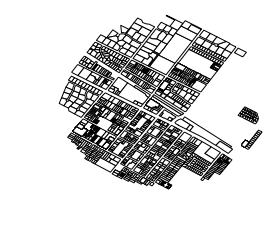

In [72]:
fruit_lv = geopandas.read_file('Landvision/Merged/fruit_lv.shp')
mp_lv = geopandas.read_file('Landvision/Merged/mp_lv.shp')
soto_lv = geopandas.read_file('Landvision/Merged/soto_lv.shp')
sl_lv = geopandas.read_file('Landvision/Merged/sl_lv.shp')

f, ax = plt.subplots(1, figsize=(4, 4))
ax = mp_pz.plot(ax = ax, color='white', edgecolor='black', linewidth=1)
ax.set_axis_off()
plt.show()

In [8]:
#fruit_lv[fruit_lv['apn'] == '33-2132-61']

In [9]:
mp_lv.columns

Index(['level_0', 'PARCEL_APN', 'ASSESSEE_M', 'ASSESSEE_1', 'ASSESSEE_2',
       'ASSESSEE_3', 'ASSESSEE_O', 'OWNER_NAME', 'MAIL_ADDR', 'MAIL_UNIT_',
       'MAIL_UNI_1', 'MAIL_CITY', 'OWNER_OCCU', 'SITE_ADDR', 'SITE_CITY',
       'SITE_UNIT_', 'SITE_UNI_1', 'ASMT_OWNER', 'VAL_ASSD', 'VAL_ASSD_I',
       'VAL_ASSD_L', 'IMPRV_PCT', 'BEDROOMS', 'TAXAPN', 'index_righ', 'index',
       'APAGE', 'APN', 'APN_FLAG', 'BLOCK', 'BOOK', 'LOT', 'SBE_NO', 'SUBLOT',
       'PARCEL_ID', 'PERIMETER', 'RETIRE_DAT', 'REV_DATE', 'SRC_AGENCY',
       'SRC_COMMEN', 'SRC_CRTL_S', 'SRC_DATE', 'SRC_DOC', 'SRC_FINL_S',
       'TRACT_ID', 'TRANSFER', 'PROPERTY_R', 'key', 'name', 'lat', 'lon',
       'index_ri_1', 'apn_1', 'fld_firm_z', 'gp_values1', 'gpz_gen_pl',
       'gpz_z_labe', 'zone_base', 'dist_stati', 'parcel_are', 'parcel_len',
       'parcel_quo', 'geometry'],
      dtype='object')

In [10]:
fruit_lv['ASMT_OWNER']=fruit_lv['ASMT_OWNER'].fillna('N')
mp_lv['ASMT_OWNER']=mp_lv['ASMT_OWNER'].fillna('N')
soto_lv['ASMT_OWNER']=soto_lv['ASMT_OWNER'].fillna('N')
sl_lv['ASMT_OWNER']=sl_lv['ASMT_OWNER'].fillna('N')

fruit_lv['Renter_Occupied'] = 'N'
mp_lv['Renter_Occupied'] = 'N'
soto_lv['Renter_Occupied'] = 'N'
sl_lv['Renter_Occupied'] = 'N'

fruit_lv.loc[(((fruit_lv['ASMT_OWNER'].str.contains('N')) | 
              (fruit_lv['OWNER_OCCU'].str.contains('N'))) & 
              (fruit_lv['BEDROOMS'] > 0)),'Renter_Occupied'] = 'Y'
mp_lv.loc[(((mp_lv['ASMT_OWNER'].str.contains('N')) | 
              (mp_lv['OWNER_OCCU'].str.contains('N'))) & 
              (mp_lv['BEDROOMS'] > 0)),'Renter_Occupied'] = 'Y'
soto_lv.loc[(((soto_lv['ASMT_OWNER'].str.contains('N')) | 
              (soto_lv['OWNER_OCCU'].str.contains('N'))) & 
              (soto_lv['BEDROOMS'] > 0)),'Renter_Occupied'] = 'Y'
sl_lv.loc[(((sl_lv['ASMT_OWNER'].str.contains('N')) | 
              (sl_lv['OWNER_OCCU'].str.contains('N'))) & 
              (sl_lv['BEDROOMS'] > 0)),'Renter_Occupied'] = 'Y'

mp_lv.head(3)

,level_0,PARCEL_APN,ASSESSEE_M,ASSESSEE_1,ASSESSEE_2,ASSESSEE_3,ASSESSEE_O,OWNER_NAME,MAIL_ADDR,MAIL_UNIT_,...,gp_values1,gpz_gen_pl,gpz_z_labe,zone_base,dist_stati,parcel_are,parcel_len,parcel_quo,geometry,Renter_Occupied
0,197594,061422400,247 EL CAMINO REAL,None,MENLO PARK,None,BELTRAMO ENTERPRISES INC,BELTRAMO ENTERPRISES INC,247 EL CAMINO REAL,None,...,El Camino Real/Downtown Specific Plan,ECRDSP,SP-ECR-D,El Camino Real/Downtown Specific Plan,748.301151,58297.823845,972.364081,0.774828,POINT (-122.1900072111691 37.45770473640393),N
1,198247,061390030,407 ENCINAL AVE,None,MENLO PARK,None,METOYER CHARLES TR HARPERMETOYER GWENDOLYN TR,"METOYER, CHARLES MITCHELL",407 ENCINAL AVE,None,...,Residential Low Density,RL,R1S,Single-Family Residential,777.096325,12958.075023,455.519661,0.784760,POINT (-122.1886279668276 37.45968944891538),N
2,198248,061350210,102 ENCINAL AVE,None,ATHERTON,None,SPENCER CRISTINA OLIVETTI TR,"SPENCER, CRISTINA OLIVETTI",102 ENCINAL AVE,None,...,None,None,None,Single-Family Residential,799.875968,35679.927078,759.786405,0.776697,POINT (-122.1879204193852 37.46045850115596),N


In [11]:
sl_lv.head(3)

,index,PARCEL_APN,ASSESSEE_M,ASSESSEE_1,ASSESSEE_2,ASSESSEE_3,ASSESSEE_O,OWNER_NAME,MAIL_ADDR,MAIL_UNIT_,...,BEDROOMS,TAXAPN,index_righ,assetid,id,shape_area,parcel_are,bpp,geometry,Renter_Occupied
0,899242,5440010028,6436 ELMER AVE,None,NORTH HOLLYWOOD,None,COSTELLO MICHAEL D,"COSTELLO, MICHAEL D",6436 ELMER AVE,None,...,4,5440-010-028,5440010028,1333238.0,340.0,4777.458116,4796.365690,5440010028,POINT (-118.2577701948494 34.10066884885604),Y
1,899243,5440010001,2416 TEVIOT ST,None,LOS ANGELES,None,WILBUR WILLIAM,"WILBUR, WILLIAM",2416 TEVIOT ST,None,...,2,5440-010-001,5440010001,1333608.0,355.0,2499.961083,2509.854549,5440010001,POINT (-118.2578607152466 34.10053278214833),N
2,899247,5440010019,2422 MCCREADY AVE,None,LOS ANGELES,None,MATULIONIS MARIJA L,"MATULIONIS, MANJIA LAIMA",2422 MCCREADY AVE,None,...,2,5440-010-019,5440010019,2665764.0,657.0,5199.923853,5220.512195,5440010019,POINT (-118.2569449840967 34.1008030903691),N


In [12]:
sl_lv.columns

Index(['index', 'PARCEL_APN', 'ASSESSEE_M', 'ASSESSEE_1', 'ASSESSEE_2',
       'ASSESSEE_3', 'ASSESSEE_O', 'OWNER_NAME', 'MAIL_ADDR', 'MAIL_UNIT_',
       'MAIL_UNI_1', 'MAIL_CITY', 'OWNER_OCCU', 'SITE_ADDR', 'SITE_CITY',
       'SITE_UNIT_', 'SITE_UNI_1', 'ASMT_OWNER', 'VAL_ASSD', 'VAL_ASSD_I',
       'VAL_ASSD_L', 'IMPRV_PCT', 'BEDROOMS', 'TAXAPN', 'index_righ',
       'assetid', 'id', 'shape_area', 'parcel_are', 'bpp', 'geometry',
       'Renter_Occupied'],
      dtype='object')

In [13]:
fruit_renter = pd.DataFrame(fruit_lv['Renter_Occupied'].groupby(fruit_lv['apn']).sum())
mp_renter = pd.DataFrame(mp_lv['Renter_Occupied'].groupby(mp_lv['PARCEL_ID']).sum())
soto_renter = pd.DataFrame(soto_lv['Renter_Occupied'].groupby(soto_lv['bpp']).sum())
sl_renter = pd.DataFrame(sl_lv['Renter_Occupied'].groupby(sl_lv['bpp']).sum())

fruit_renter['apn'] = fruit_renter.index
mp_renter['PARCEL_ID'] = mp_renter.index
soto_renter['bpp'] = soto_renter.index
sl_renter['bpp'] = sl_renter.index

soto_renter.head(3)

,Renter_Occupied,bpp
bpp,,
5174006014,N,5174006014
5174006015,Y,5174006015
5174006016,N,5174006016


In [14]:
fruit_renter['RENTER_OCCUPIED'] = 0
fruit_renter.loc[(fruit_renter['Renter_Occupied'].str.contains('Y')),'RENTER_OCCUPIED'] = 1

mp_renter['RENTER_OCCUPIED'] = 0
mp_renter.loc[(mp_renter['Renter_Occupied'].str.contains('Y')),'RENTER_OCCUPIED'] = 1

soto_renter['RENTER_OCCUPIED'] = 0
soto_renter.loc[(soto_renter['Renter_Occupied'].str.contains('Y')),'RENTER_OCCUPIED'] = 1

sl_renter['RENTER_OCCUPIED'] = 0
sl_renter.loc[(sl_renter['Renter_Occupied'].str.contains('Y')),'RENTER_OCCUPIED'] = 1

In [15]:
fruit_pz.head(3)

,index,apn,apn_sort,book,centroid_x,centroid_y,clca_categ,comments,date_creat,date_updat,...,index_righ,BASEZONE,OVERLAY,ZNLABEL,zone_base,dist_stati,parcel_are,parcel_len,parcel_quo,geometry
0,5,33-2127-11,033 212701100,33,6.064269e+06,2.111500e+06,None,None,2004-06-07,2004-06-07,...,30.0,RM-3,None,RM-3,Multi-Family Residential,756.169981,3804.304088,303.358662,0.519485,POLYGON ((-122.2209985275363 37.78121209779937...
1,6,33-2136-27-1,033 213602701,33,6.065076e+06,2.110309e+06,None,None,2004-06-07,2004-06-07,...,27.0,RM-2,None,RM-2,Multi-Family Residential,622.041286,5958.258968,345.136906,0.628561,POLYGON ((-122.2181174853883 37.77796759230895...
2,8,25-722-16,025 072201600,25,6.063121e+06,2.111167e+06,None,None,2004-06-07,2004-06-07,...,33.0,RM-2,None,RM-2,Multi-Family Residential,607.809772,6653.322477,400.889705,0.520235,POLYGON ((-122.2249961267633 37.78043837887684...


In [16]:
fruit_own_pz = fruit_pz.merge(fruit_renter, on='apn')
mp_own_pz = mp_pz.merge(mp_renter, on='PARCEL_ID')
soto_own_pz = soto_pz_agg.merge(soto_renter, on='bpp')
sl_own_pz = sl_pz_agg.merge(sl_renter, on='bpp')

C:\Users\jared\Miniconda3\envs\osmnx\lib\site-packages\geopandas\geodataframe.py:475: FutureWarning: 'apn' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  result = DataFrame.merge(self, *args, **kwargs)
C:\Users\jared\Miniconda3\envs\osmnx\lib\site-packages\geopandas\geodataframe.py:475: FutureWarning: 'PARCEL_ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  result = DataFrame.merge(self, *args, **kwargs)
C:\Users\jared\Miniconda3\envs\osmnx\lib\site-packages\geopandas\geodataframe.py:475: FutureWarning: 'bpp' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  result = DataFrame.merge(self, *args, **kwargs)


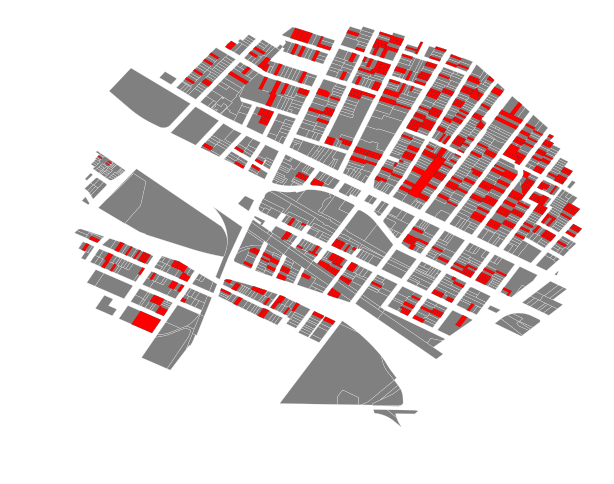

In [17]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax = fruit_own_pz[fruit_own_pz['RENTER_OCCUPIED'] == 0].plot(ax = ax, color='gray', edgecolor='white', linewidth=.2)
ax = fruit_own_pz[fruit_own_pz['RENTER_OCCUPIED'] == 1].plot(ax = ax, color='red', edgecolor='black', linewidth=.2)

ax.set_axis_off()
plt.savefig('Graphics/fruitvale_renters.png')
plt.show()

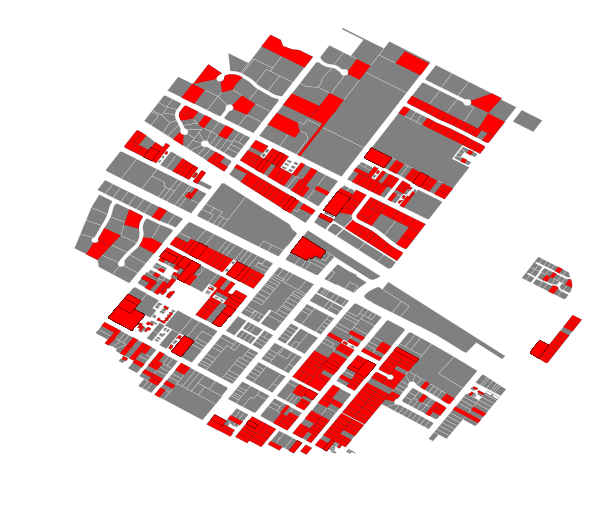

In [18]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax = mp_own_pz[mp_own_pz['RENTER_OCCUPIED'] == 0].plot(ax = ax, color='gray', edgecolor='white', linewidth=.2)
ax = mp_own_pz[mp_own_pz['RENTER_OCCUPIED'] == 1].plot(ax = ax, color='red', edgecolor='black', linewidth=.2)

ax.set_axis_off()
plt.savefig('Graphics/menlopark_renters.png')
plt.show()

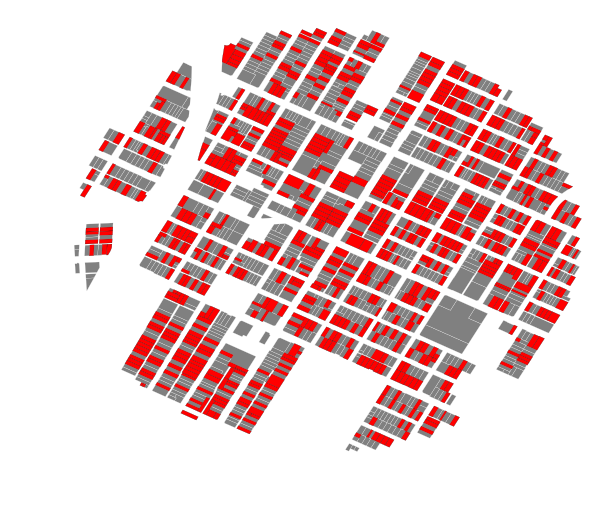

In [19]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax = soto_own_pz[soto_own_pz['RENTER_OCCUPIED'] == 0].plot(ax = ax, color='gray', edgecolor='white', linewidth=.2)
ax = soto_own_pz[soto_own_pz['RENTER_OCCUPIED'] == 1].plot(ax = ax, color='red', edgecolor='black', linewidth=.2)

ax.set_axis_off()
plt.savefig('Graphics/boyleheights_renters.png')
plt.show()

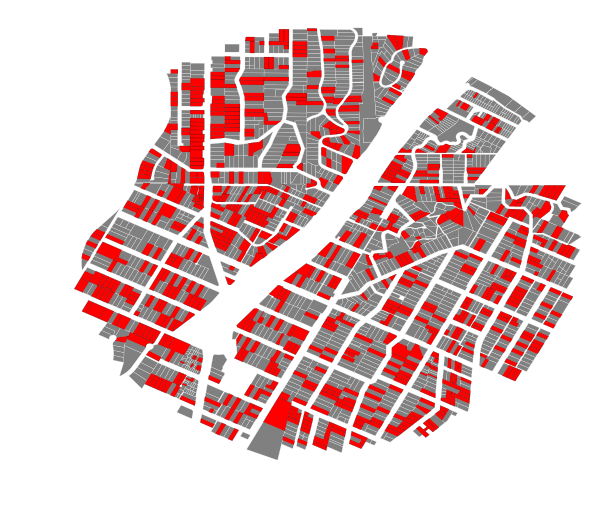

In [20]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax = sl_own_pz[sl_own_pz['RENTER_OCCUPIED'] == 0].plot(ax = ax, color='gray', edgecolor='white', linewidth=.2)
ax = sl_own_pz[sl_own_pz['RENTER_OCCUPIED'] == 1].plot(ax = ax, color='red', edgecolor='black', linewidth=.2)

ax.set_axis_off()  
plt.savefig('Graphics\silverlake_renters.png')
plt.show()

In [21]:
print(len(mp_pz))
print(len(mp_own_pz))

mp_pz2 = mp_pz.drop_duplicates('PARCEL_ID')
mp_own_pz2 = mp_own_pz.drop_duplicates('PARCEL_ID')

print(len(mp_pz2))
print(len(mp_own_pz2))

1334
1299
1021
987


In [22]:
fruit_areas = pd.DataFrame(fruit_own_pz['parcel_are'].groupby(fruit_own_pz['RENTER_OCCUPIED']).sum())
fruit_areas.rename(columns={'parcel_are':'Fruitvale'}, inplace=True)

mp_areas = pd.DataFrame(mp_own_pz2['parcel_are'].groupby(mp_own_pz2['RENTER_OCCUPIED']).sum())
mp_areas.rename(columns={'parcel_are':'Menlo Park'}, inplace=True)

soto_areas = pd.DataFrame(soto_own_pz['parcel_are'].groupby(soto_own_pz['RENTER_OCCUPIED']).sum())
soto_areas.rename(columns={'parcel_are':'Boyle Heights'}, inplace=True)

sl_areas = pd.DataFrame(sl_own_pz['parcel_are'].groupby(sl_own_pz['RENTER_OCCUPIED']).sum())
sl_areas.rename(columns={'parcel_are':'Silver Lake'}, inplace=True)

land_use_areas = pd.merge(pd.merge(pd.merge(fruit_areas,mp_areas,how='outer',on='RENTER_OCCUPIED'),
                                   soto_areas,how='outer',on='RENTER_OCCUPIED'),
                          sl_areas,how='outer',on='RENTER_OCCUPIED')

land_use_areas

,Fruitvale,Menlo Park,Boyle Heights,Silver Lake
RENTER_OCCUPIED,,,,
0,1.048916e+07,9.187412e+06,7.390241e+06,9.434189e+06
1,2.053360e+06,3.931238e+06,5.091943e+06,4.973126e+06


In [23]:
land_use_areas.to_csv('Output/renter_occupied_areas.csv')

## Now to look at Improvement/Land Value Ratio

First need to remove duplicate TAXAPN, this is mostly an issue in Menlo Park since observations were duplicated when they were merged onto duplicate parcel geometries.

Then we need to aggregate by PARCEL_APN. This is mostly a concern in Fruitvale and Menlo Park, since some apartments share the same PARCEL_APN since they are part of the same building. I am doing this so that acreage/parcels are not double-counted in the analysis.

In [48]:
print(len(mp_lv))
mp_lv2 = mp_lv.drop_duplicates('TAXAPN')
print(len(mp_lv2))

7844
1270


In [78]:
assd_col = ['VAL_ASSD','VAL_ASSD_I','VAL_ASSD_L']

fruit_imp = pd.DataFrame(fruit_lv.loc[:,assd_col].groupby(fruit_lv['PARCEL_APN']).sum())
mp_imp = pd.DataFrame(mp_lv2.loc[:,assd_col].groupby(mp_lv2['PARCEL_APN']).sum())
sl_imp = pd.DataFrame(sl_lv.loc[:,assd_col].groupby(sl_lv['bpp']).sum())

fruit_imp['PARCEL_APN'] = fruit_imp.index
mp_imp['PARCEL_APN'] = mp_imp.index
sl_imp['bpp'] = sl_imp.index

mp_imp.head(3)

C:\Users\jared\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,bpp,PARCEL_APN
PARCEL_APN,,,,,
061281010,233314,134437,98877,0.0,061281010
061281020,5956994,3234285,2722709,0.0,061281020
061281030,3563500,260622,3302878,0.0,061281030


In [79]:
keep_col = ['PARCEL_APN', 'parcel_are','bpp']

fruit_val = fruit_imp.merge(fruit_lv.drop_duplicates('PARCEL_APN').loc[:,keep_col], on='PARCEL_APN')
mp_val = mp_imp.merge(mp_lv.drop_duplicates('PARCEL_APN').loc[:,keep_col], on='PARCEL_APN')
sl_val = sl_imp.merge(sl_lv.drop_duplicates('bpp').loc[:,keep_col], on='bpp')

print(len(fruit_lv))
print(len(fruit_imp))
print(len(fruit_val))

print(len(mp_lv))
print(len(mp_imp))
print(len(mp_val))

print(len(sl_lv))
print(len(sl_lv.drop_duplicates('bpp')))
print(len(sl_imp))
print(len(sl_val))


fruit_val.head(3)

1793
1641
1641
7844
987
987
2336
2223
2223
2223


C:\Users\jared\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: 'PARCEL_APN' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jared\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: 'PARCEL_APN' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.
C:\Users\jared\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: FutureWarning: 'bpp' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """


,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,bpp_x,PARCEL_APN,parcel_are,bpp_y
0,0,0,0,0.0,19-84-29,3760.051962,NaN
1,132854,76517,56337,0.0,19-85-1-1,3100.261053,NaN
2,133545,93964,39581,0.0,19-85-18-1,3883.872166,NaN


In [92]:
fruit_val['IMPRV_PCT'] = fruit_val['VAL_ASSD_I'] / fruit_val['VAL_ASSD']
mp_val['IMPRV_PCT'] = mp_val['VAL_ASSD_I'] / mp_val['VAL_ASSD']
soto_lv['IMPRV_PCT'] = soto_lv['VAL_ASSD_I'] / soto_lv['VAL_ASSD']
sl_val['IMPRV_PCT'] = sl_val['VAL_ASSD_I'] / sl_val['VAL_ASSD']

fruit_val.head(3)

,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,bpp_x,PARCEL_APN,parcel_are,bpp_y,IMPRV_PCT,Imp_Bucket
0,0,0,0,0.0,19-84-29,3760.051962,NaN,NaN,N/A
1,132854,76517,56337,0.0,19-85-1-1,3100.261053,NaN,0.575948,50-75
2,133545,93964,39581,0.0,19-85-18-1,3883.872166,NaN,0.703613,50-75


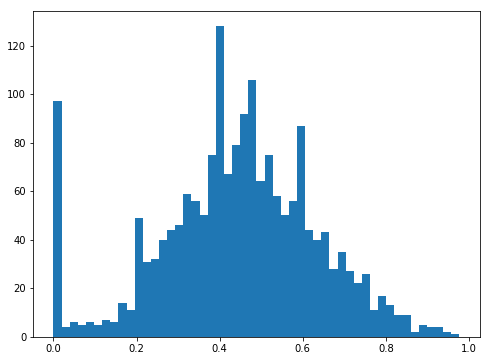

In [93]:
plt.figure(1, figsize=(8,6), )
#plt.xlabel('Lot Coverage', fontsize=12)
#plt.ylabel('Number of Parcels', fontsize=12)
ax = plt.hist(soto_lv['IMPRV_PCT'], bins=50)
#plt.savefig('parcel_area_hist.png')
plt.show()

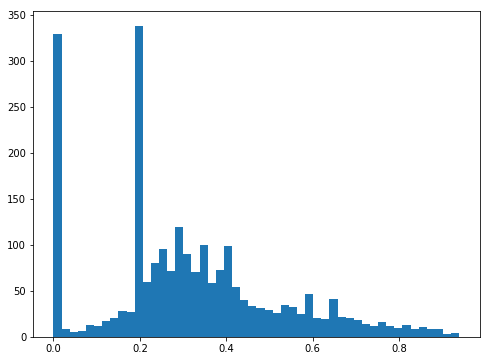

In [94]:
plt.figure(1, figsize=(8,6), )
#plt.xlabel('Lot Coverage', fontsize=12)
#plt.ylabel('Number of Parcels', fontsize=12)
ax = plt.hist(sl_lv['IMPRV_PCT'], bins=50)
#plt.savefig('parcel_area_hist.png')
plt.show()

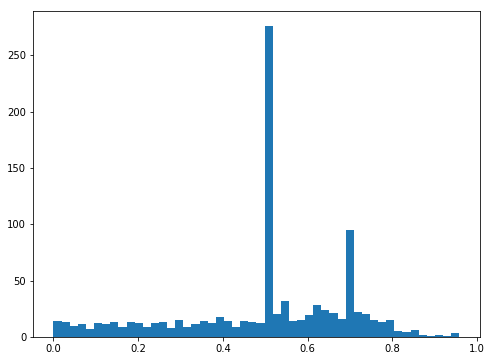

In [95]:
plt.figure(1, figsize=(8,6), )
#plt.xlabel('Lot Coverage', fontsize=12)
#plt.ylabel('Number of Parcels', fontsize=12)
ax = plt.hist(mp_val['IMPRV_PCT'], bins=50)
#plt.savefig('parcel_area_hist.png')
plt.show()

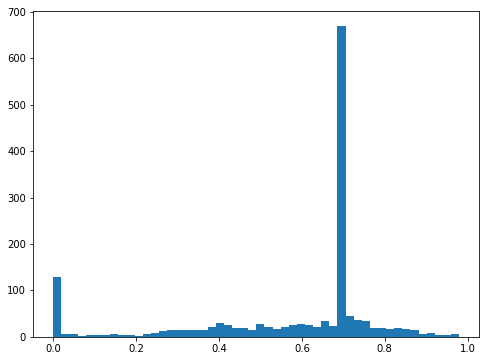

In [96]:
plt.figure(1, figsize=(8,6), )
#plt.xlabel('Lot Coverage', fontsize=12)
#plt.ylabel('Number of Parcels', fontsize=12)
ax = plt.hist(fruit_val['IMPRV_PCT'], bins=50)
#plt.savefig('parcel_area_hist.png')
plt.show()

In [97]:
fruit_val['Imp_Bucket'] = 'N/A'
mp_val['Imp_Bucket'] = 'N/A'
soto_lv['Imp_Bucket'] = 'N/A'
sl_val['Imp_Bucket'] = 'N/A'

In [98]:
fruit_val.loc[(fruit_val['IMPRV_PCT'] < .25),'Imp_Bucket'] = '0-25'
fruit_val.loc[((fruit_val['IMPRV_PCT'] >= .25) & (fruit_val['IMPRV_PCT'] < .5)), 'Imp_Bucket'] = '25-50'
fruit_val.loc[((fruit_val['IMPRV_PCT'] >= .5) & (fruit_val['IMPRV_PCT'] < .75)), 'Imp_Bucket'] = '50-75'
fruit_val.loc[(fruit_val['IMPRV_PCT'] >= .75),'Imp_Bucket'] = '75-100'

fruit_val.head(2)

,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,bpp_x,PARCEL_APN,parcel_are,bpp_y,IMPRV_PCT,Imp_Bucket
0,0,0,0,0.0,19-84-29,3760.051962,NaN,NaN,N/A
1,132854,76517,56337,0.0,19-85-1-1,3100.261053,NaN,0.575948,50-75


In [99]:
mp_val.loc[(mp_val['IMPRV_PCT'] < .25),'Imp_Bucket'] = '0-25'
mp_val.loc[((mp_val['IMPRV_PCT'] >= .25) & (mp_val['IMPRV_PCT'] < .5)), 'Imp_Bucket'] = '25-50'
mp_val.loc[((mp_val['IMPRV_PCT'] >= .5) & (mp_val['IMPRV_PCT'] < .75)), 'Imp_Bucket'] = '50-75'
mp_val.loc[(mp_val['IMPRV_PCT'] >= .75),'Imp_Bucket'] = '75-100'

mp_val.head(2)

,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,bpp_x,PARCEL_APN,parcel_are,bpp_y,IMPRV_PCT,Imp_Bucket
0,233314,134437,98877,0.0,061281010,43327.470999,NaN,0.576206,50-75
1,5956994,3234285,2722709,0.0,061281020,43534.962850,NaN,0.542939,50-75


In [100]:
soto_lv.loc[(soto_lv['IMPRV_PCT'] < .25),'Imp_Bucket'] = '0-25'
soto_lv.loc[((soto_lv['IMPRV_PCT'] >= .25) & (soto_lv['IMPRV_PCT'] < .50)), 'Imp_Bucket'] = '25-50'
soto_lv.loc[((soto_lv['IMPRV_PCT'] >= .50) & (soto_lv['IMPRV_PCT'] < .75)), 'Imp_Bucket'] = '50-75'
soto_lv.loc[(soto_lv['IMPRV_PCT'] >= .75),'Imp_Bucket'] = '75-100'

soto_lv.head(2)

,index,PARCEL_APN,ASSESSEE_M,ASSESSEE_1,ASSESSEE_2,ASSESSEE_3,ASSESSEE_O,OWNER_NAME,MAIL_ADDR,MAIL_UNIT_,...,BEDROOMS,TAXAPN,index_righ,assetid,id,shape_area,parcel_are,bpp,geometry,Imp_Bucket
0,1015382,5175033013,150 N SANTA ANITA AVE,300,ARCADIA,STE,JCGREENFIELD PROPERTIES LLC,JCGREENFIELD PROPERTIES LLC,150 N SANTA ANITA AVE STE 300,300,...,14,5175-033-013,5175033013,4433689.0,1158.0,6046.221737,6070.605348,5175033013,POINT (-118.2129391737872 34.05042458722729),25-50
1,1015387,5174006033,1901 MICHIGAN AVE,None,LOS ANGELES,None,HUERTA EZEQUIEL & ANA,"HUERTA, EZEQUIEL",1901 MICHIGAN AVE,None,...,8,5174-006-033,5174006033,1485100.0,89.0,3825.051682,3840.451474,5174006033,POINT (-118.2160197681097 34.04845250899798),50-75


In [110]:
sl_val.loc[(sl_val['IMPRV_PCT'] < .25),'Imp_Bucket'] = '0-25'
sl_val.loc[((sl_val['IMPRV_PCT'] >= .25) & (sl_val['IMPRV_PCT'] < .50)), 'Imp_Bucket'] = '25-50'
sl_val.loc[((sl_val['IMPRV_PCT'] >= .50) & (sl_val['IMPRV_PCT'] < .75)), 'Imp_Bucket'] = '50-75'
sl_val.loc[(sl_val['IMPRV_PCT'] >= .75),'Imp_Bucket'] = '75-100'

sl_val.head(2)

,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,bpp,PARCEL_APN,parcel_are,IMPRV_PCT,Imp_Bucket
0,220627,155781,64846,5420002001,5420002001,6149.620724,0.706083,50-75
1,59590,22959,36631,5420002002,5420002002,6149.622451,0.385283,25-50


In [111]:
fruit_group1 = pd.DataFrame(fruit_val['parcel_are'].groupby(fruit_val['Imp_Bucket']).sum())
mp_group1 = pd.DataFrame(mp_val['parcel_are'].groupby(mp_val['Imp_Bucket']).sum())
soto_group1 = pd.DataFrame(soto_lv['parcel_are'].groupby(soto_lv['Imp_Bucket']).sum())
sl_group1 = pd.DataFrame(sl_val['parcel_are'].groupby(sl_val['Imp_Bucket']).sum())

fruit_group1.rename(columns={'parcel_are':'Fruitvale SF'}, inplace=True)
mp_group1.rename(columns={'parcel_are':'Menlo Park SF'}, inplace=True)
soto_group1.rename(columns={'parcel_are':'Boyle Heights SF'}, inplace=True)
sl_group1.rename(columns={'parcel_are':'Silver Lake SF'}, inplace=True)

parcel_group1 = pd.merge(pd.merge(pd.merge(fruit_group1,mp_group1,how='outer',on='Imp_Bucket'),
                                  soto_group1,how='outer',on='Imp_Bucket'), 
                         sl_group1,how='outer',on='Imp_Bucket')

parcel_group1

,Fruitvale SF,Menlo Park SF,Boyle Heights SF,Silver Lake SF
Imp_Bucket,,,,
0-25,1.220772e+06,2.636964e+06,1.873833e+06,5.627542e+06
25-50,1.364104e+06,2.037538e+06,5.520297e+06,5.859135e+06
50-75,6.487363e+06,6.322994e+06,4.226795e+06,2.225130e+06
75-100,1.589530e+06,1.646987e+06,8.982471e+05,6.955069e+05
N/A,1.918438e+06,4.741681e+05,NaN,NaN


In [112]:
parcel_group1.to_csv('Output/IL_ratios.csv')

In [45]:
len(sl_lv)

2336

In [109]:
columns = ['PARCEL_APN','SITE_ADDR','SITE_CITY','SITE_UNIT_','SITE_UNI_1','ASMT_OWNER', 'Imp_Bucket',
           'VAL_ASSD','VAL_ASSD_I','VAL_ASSD_L','IMPRV_PCT','BEDROOMS','TAXAPN','parcel_are']

sl_val.loc[:,columns][sl_val['Imp_Bucket'] == 'N/A']

,PARCEL_APN,SITE_ADDR,SITE_CITY,SITE_UNIT_,SITE_UNI_1,ASMT_OWNER,Imp_Bucket,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,IMPRV_PCT,BEDROOMS,TAXAPN,parcel_are
0,5420002001,NaN,NaN,NaN,NaN,NaN,N/A,220627,155781,64846,0.706083,NaN,NaN,6149.620724
17,5420003012,NaN,NaN,NaN,NaN,NaN,N/A,185692,112877,72815,0.607872,NaN,NaN,5125.854817
22,5420003017,NaN,NaN,NaN,NaN,NaN,N/A,145808,94869,50939,0.650643,NaN,NaN,2452.822462
62,5420005013,NaN,NaN,NaN,NaN,NaN,N/A,67520,40396,27124,0.598282,NaN,NaN,7516.852784
84,5420006004,NaN,NaN,NaN,NaN,NaN,N/A,51873,34449,17424,0.664103,NaN,NaN,5431.050266
95,5420006015,NaN,NaN,NaN,NaN,NaN,N/A,463059,261703,201356,0.565161,NaN,NaN,4584.547343
101,5420006021,NaN,NaN,NaN,NaN,NaN,N/A,49505,35959,13546,0.726371,NaN,NaN,4439.464239
105,5420007001,NaN,NaN,NaN,NaN,NaN,N/A,33348,19802,13546,0.593799,NaN,NaN,2576.030227
116,5420008001,NaN,NaN,NaN,NaN,NaN,N/A,143239,93154,50085,0.650340,NaN,NaN,6392.016800
117,5420008002,NaN,NaN,NaN,NaN,NaN,N/A,323192,210220,112972,0.650449,NaN,NaN,6257.541114


In [70]:
mp_val.loc[:,columns][mp_val['Imp_Bucket'] == 'N/A']

,PARCEL_APN,SITE_ADDR,SITE_CITY,SITE_UNIT_,SITE_UNI_1,ASMT_OWNER,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,IMPRV_PCT,BEDROOMS,TAXAPN,parcel_are
472,071092290,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,86451.140529
498,071094180,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,24245.005135
559,071102400,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,99525.002186
616,071273160,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,26862.159705
637,071281160,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,43725.800111
656,071283140,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,33231.422218
663,071284080,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,4247.656149
664,071284100,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,20738.427891
674,071285160,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,43725.845600


# Checking whether NA IMPRV_PCT should actually be 0

In [106]:
columns = ['PARCEL_APN','SITE_ADDR','SITE_CITY','SITE_UNIT_','SITE_UNI_1','ASMT_OWNER',
           'VAL_ASSD','VAL_ASSD_I','VAL_ASSD_L','IMPRV_PCT','BEDROOMS','TAXAPN','parcel_are']


fruit_lv.loc[:,columns][fruit_lv['PARCEL_APN'] == '25-662-2']

,PARCEL_APN,SITE_ADDR,SITE_CITY,SITE_UNIT_,SITE_UNI_1,ASMT_OWNER,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,IMPRV_PCT,BEDROOMS,TAXAPN,parcel_are
782,25-662-2,FRUITVALE AVE,OAKLAND,None,None,None,150000,0,150000,NaN,0,25-662-2,8342.475994


In [106]:
fruit_lv.loc[:,columns][fruit_lv['PARCEL_APN'] == '25-667-13']

,PARCEL_APN,SITE_ADDR,SITE_CITY,SITE_UNIT_,SITE_UNI_1,ASMT_OWNER,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,IMPRV_PCT,BEDROOMS,TAXAPN,parcel_are
659,25-667-13,3034 FORD ST,OAKLAND,None,None,N,208248,0,208248,NaN,0,25-667-13,2507.576327


In [107]:
fruit_lv.loc[:,columns][fruit_lv['PARCEL_APN'] == '25-720-7-2']

,PARCEL_APN,SITE_ADDR,SITE_CITY,SITE_UNIT_,SITE_UNI_1,ASMT_OWNER,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,IMPRV_PCT,BEDROOMS,TAXAPN,parcel_are
394,25-720-7-2,2956 INTERNATIONAL BLVD,OAKLAND,None,None,N,1664640,0,1664640,NaN,0,25-720-7-2,26705.165314


In [84]:
fruit_val[fruit_val['IMPRV_PCT'] == 0]

,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,PARCEL_APN,parcel_are,IMPRV_PCT
64,150000,0,150000,25-662-2,8342.475994,0.0
65,240000,0,240000,25-662-3-2,13257.506269,0.0
68,635000,0,635000,25-663-3-2,35365.777030,0.0
69,112900,0,112900,25-663-4-2,5925.314997,0.0
75,208248,0,208248,25-667-13,2507.576327,0.0
76,150000,0,150000,25-667-14,5015.040150,0.0
87,43062,0,43062,25-667-8,3061.101581,0.0
103,318990,0,318990,25-669-14-1,4997.290242,0.0
104,156326,0,156326,25-669-15,2498.607187,0.0
106,21002,0,21002,25-669-17,3697.627790,0.0


In [108]:
soto_lv.loc[:,columns][soto_lv['IMPRV_PCT'].isna()]

,PARCEL_APN,SITE_ADDR,SITE_CITY,SITE_UNIT_,SITE_UNI_1,ASMT_OWNER,VAL_ASSD,VAL_ASSD_I,VAL_ASSD_L,IMPRV_PCT,BEDROOMS,TAXAPN,parcel_are
20,5174006027,1915 MICHIGAN AVE,LOS ANGELES,None,None,N,62428,0,62428,NaN,0,5174-006-027,8960.395057
21,5174006025,1921 MICHIGAN AVE,LOS ANGELES,None,None,N,19147,0,19147,NaN,0,5174-006-025,5973.585252
22,5174006024,1923 MICHIGAN AVE,LOS ANGELES,None,None,N,386065,0,386065,NaN,0,5174-006-024,5973.606472
23,5174006021,1931 MICHIGAN AVE,LOS ANGELES,None,None,N,16567,0,16567,NaN,0,5174-006-021,4663.911926
25,5174006020,None,None,None,None,N,6184,0,6184,NaN,0,5174-006-020,7584.648394
83,5174016028,1922 E 1ST ST,LOS ANGELES,None,None,N,824186,0,824186,NaN,0,5174-016-028,7027.446514
88,5174006064,1931 MICHIGAN AVE,LOS ANGELES,None,None,N,114124,0,114124,NaN,0,5174-006-064,13257.153018
112,5183001034,2015 MICHIGAN AVE,LOS ANGELES,None,None,N,44574,0,44574,NaN,0,5183-001-034,843.399226
178,5183007900,None,None,None,None,N,51996,0,51996,NaN,0,5183-007-900,16883.755597
181,5183006909,126 N ST LOUIS ST,LOS ANGELES,None,None,N,110137,0,110137,NaN,0,5183-006-909,7402.576800


In [44]:
print(len(mp_lv))

mp_lv2 = mp_lv.drop_duplicates('TAXAPN')

print(len(mp_lv2))

7844
1270


In [54]:
print(len(fruit_lv))

fruit_lv2 = fruit_lv.drop_duplicates('PARCEL_APN')

print(len(fruit_lv2))

1793
1642


In [47]:
print(len(mp_lv))

mp_lv3 = mp_lv.drop_duplicates('PARCEL_ID')

print(len(mp_lv3))

7844
987


In [ ]:
## 2210 FARGO ST, LOS ANGELES, CA
## This was exploratory code for Silver Lake Parcels. The example parcel was APN = '5440007020', which the LA County data
## had split into two separate parcels that had different assetids but the same bpp (which was '5440007020'). 
## They were contiguous but did not overlap at all. Seems like the county did not present these as consolidated. 
## The LandVision parcel geometries shows it as one continguous parcel boundary and no sub-parcels.

f, ax = plt.subplots(1, figsize=(10, 10))
ax = sl_pz.plot(ax = ax, color='gray', edgecolor='white', linewidth=.2)
ax = sl_own_pz.plot(ax = ax, color='red', edgecolor='black', linewidth=.2)
ax.set_axis_off()  
plt.show()

path3 = 'Landvision/06037/' # select folder with data in it
#specify datatypes so FIPS numbers, etc. read in properly
dtypes = {'PARCEL_APN': 'str'}
lac_parc = pd.read_csv(path3 + 'Parcels_06037.txt', sep=',', encoding = "ISO-8859-1", dtype=dtypes)
lac_parc.head(2)

lac_parc[lac_parc['PARCEL_APN'] == '5440007020']

f, ax = plt.subplots(1, figsize=(10, 10))
ax = sl_pz[sl_pz['assetid'] == 1343936].plot(ax = ax, color='gray', edgecolor='black', linewidth=2)
ax = sl_pz[sl_pz['assetid'] == 1344329].plot(ax = ax, color='none', edgecolor='red', linewidth=1)
ax.set_axis_off()  
plt.show()












